In [1]:
import pandas as pd
import networkx as nx
import random
import heapq
import matplotlib.pyplot as plt

In [10]:
# Paso 1: Cargar los datasets
# Reemplaza 'path_to_twitch_dataset.csv' y 'path_to_twitch_edges.csv' con las rutas reales a tus archivos CSV
df_edges = pd.read_csv('large_twitch_edges.csv')
df_users = pd.read_csv('large_twitch_features.csv')
df_users = df_users[['numeric_id', 'views', 'language', 'affiliate']]

df_users = df_users.dropna()
df_edges = df_edges.dropna()

# Filtrar df_edges para incluir solo relaciones entre usuarios presentes en df_users
df_edges = df_edges[df_edges['numeric_id_1'].isin(df_users['numeric_id']) & 
                    df_edges['numeric_id_2'].isin(df_users['numeric_id'])]

# Exploración inicial de los datasets
print(df_users.head())
print(df_edges.head())

    views  mature  life_time  created_at  updated_at  numeric_id  \
0    7879       1        969  2016-02-16  2018-10-12           0   
1     500       0       2699  2011-05-19  2018-10-08           1   
2  382502       1       3149  2010-02-27  2018-10-12           2   
3     386       0       1344  2015-01-26  2018-10-01           3   
4    2486       0       1784  2013-11-22  2018-10-11           4   

   dead_account language  affiliate  
0             0       EN          1  
1             0       EN          0  
2             0       EN          1  
3             0       EN          0  
4             0       EN          0  
   numeric_id_1  numeric_id_2
0         98343        141493
1         98343         58736
2         98343        140703
3         98343        151401
4         98343        157118


In [3]:
# Paso 2: Construcción del grafo
# Construcción del grafo a partir de las relaciones de seguidores mutuos
G = nx.from_pandas_edgelist(df_edges, 'numeric_id_1', 'numeric_id_2')

# Paso 3: Incorporar atributos de los usuarios en el grafo
# Crear un diccionario de atributos de nodos
node_attributes = df_users.set_index('numeric_id').to_dict('index')

# Asignar atributos a los nodos en el grafo
nx.set_node_attributes(G, node_attributes)

In [4]:
# Paso 4: Filtrar nodos con pocas conexiones
degree_threshold = 3000 # Umbral de grado para filtrar nodos poco conectados
filtered_nodes = [node for node, degree in G.degree() if degree > degree_threshold]

# Seleccionar un subgrafo más pequeño con nodos filtrados
sampled_nodes = random.sample(filtered_nodes, 110)  # Aumentar el número de nodos
H = G.subgraph(sampled_nodes)

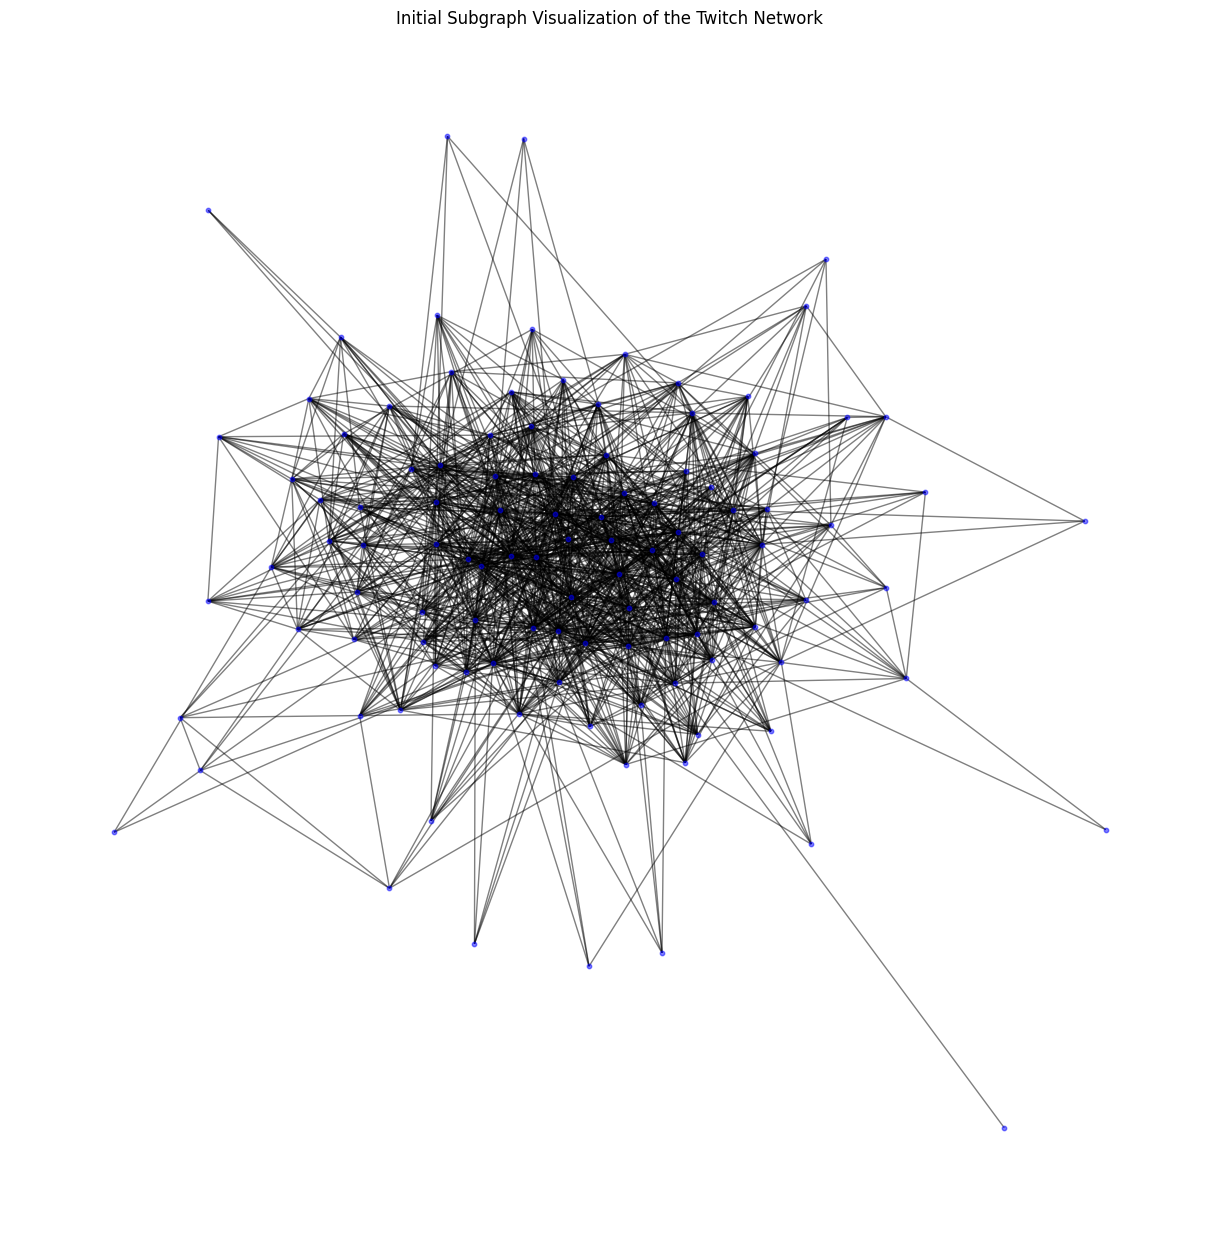

In [5]:
# Visualización inicial del subgrafo
pos = nx.spring_layout(H)
plt.figure(figsize=(12, 12))
nx.draw(H, pos, node_size=10, node_color='blue', alpha=0.5)
plt.title('Initial Subgraph Visualization of the Twitch Network')
plt.show()

In [6]:
# Paso 5: Definir el modelo de difusión (Independent Cascade)
def independent_cascade(G, seeds, steps=10):
    active = set(seeds)
    new_active = set(seeds)
    for _ in range(steps):
        new_ones = set()
        for node in new_active:
            neighbors = set(G.neighbors(node)) - active
            for neighbor in neighbors:
                if random.random() < 0.1:  # Probabilidad de influencia
                    new_ones.add(neighbor)
        if not new_ones:
            break
        active |= new_ones
        new_active = new_ones
    return len(active)

# Paso 6: Implementar el algoritmo CELF para maximización de influencia
def celf_algorithm(G, k):
    # Inicialización
    Q = []
    marginal_gain = {}
    for node in G.nodes():
        marginal_gain[node] = independent_cascade(G, [node])
        heapq.heappush(Q, (-marginal_gain[node], node, 0))

    S = []
    last_seed_gain = 0

    # Selección de los k nodos
    for _ in range(k):
        while True:
            mg, node, iter_count = heapq.heappop(Q)
            mg = -mg
            if iter_count == len(S):
                S.append(node)
                last_seed_gain = mg
                break
            else:
                marginal_gain[node] = independent_cascade(G, S + [node]) - last_seed_gain
                heapq.heappush(Q, (-marginal_gain[node], node, len(S)))

    return S

In [7]:
# Paso 7: Identificar los top-k nodos influyentes en el subgrafo
k = 10
top_k_influencers = celf_algorithm(H, k)

# Paso 8: Presentar los resultados
print("Top-k Influential Nodes in the Subgraph:", top_k_influencers)

Top-k Influential Nodes in the Subgraph: [32283, 101772, 110880, 130673, 134305, 46550, 37637, 96919, 113004, 34823]


In [11]:
# Simulación de la difusión de influencia
initial_seeds = top_k_influencers
spread = independent_cascade(H, initial_seeds)
print(f"Total number of nodes influenced by top-{k} influencers: {spread}")

Total number of nodes influenced by top-10 influencers: 93


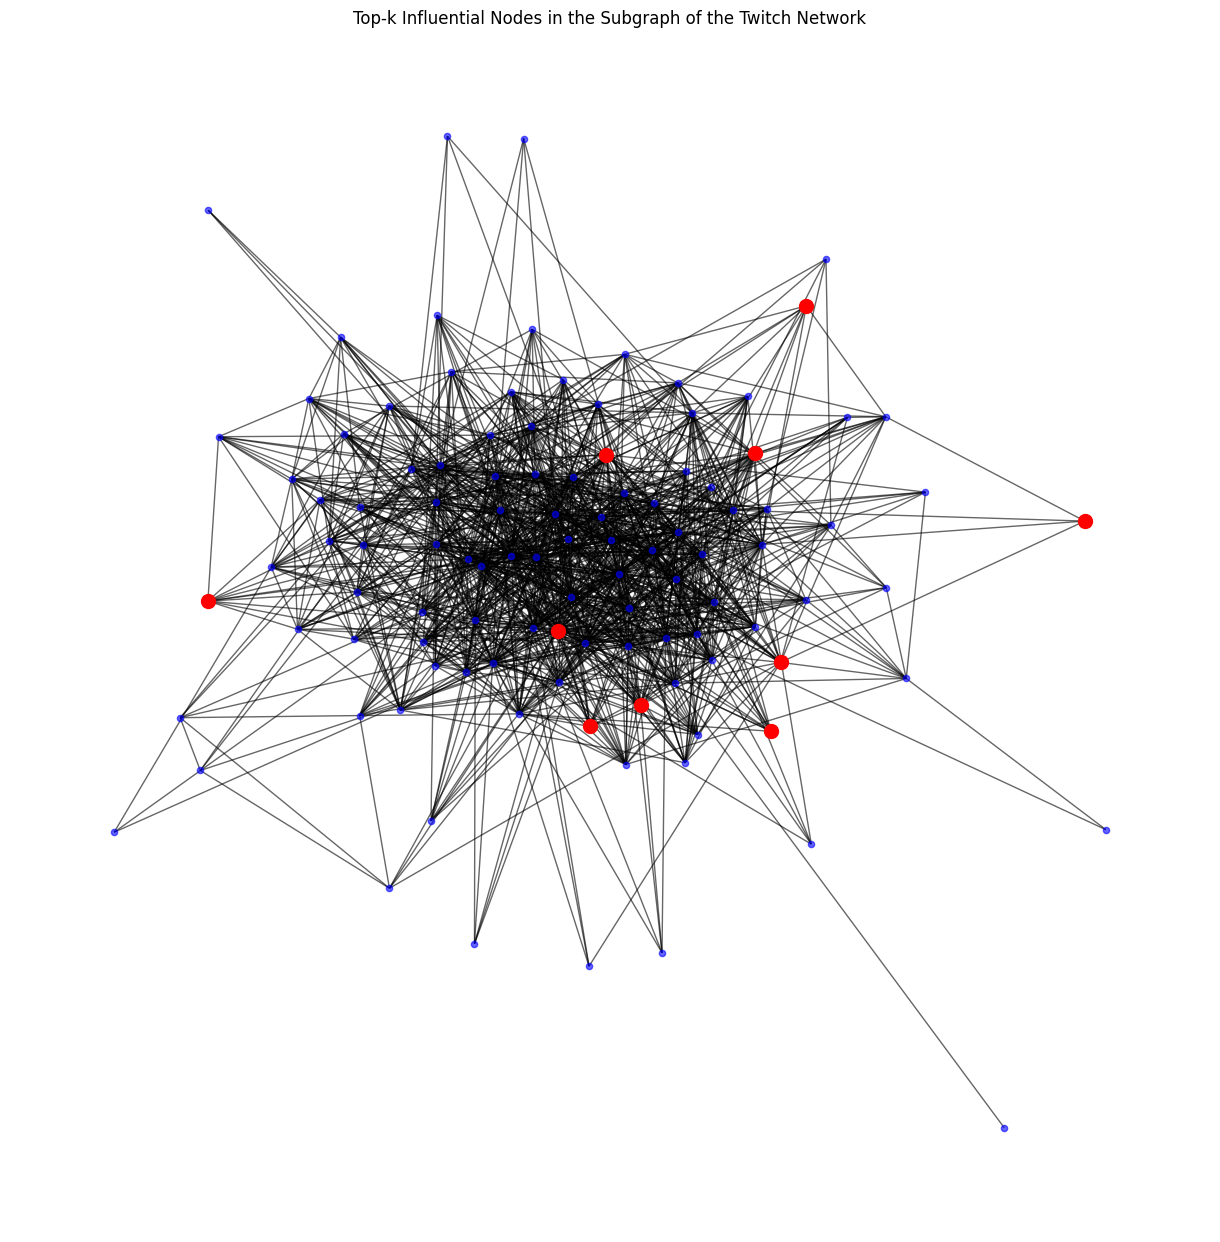

In [9]:
# Visualización del subgrafo y los nodos influyentes
plt.figure(figsize=(12, 12))
nx.draw(H, pos, node_size=20, node_color='blue', alpha=0.6)
nx.draw_networkx_nodes(H, pos, nodelist=top_k_influencers, node_size=100, node_color='red')
plt.title('Top-k Influential Nodes in the Subgraph of the Twitch Network')
plt.show()